Generating synthetic dataset: 10 identities, 20 images each
Testing verification accuracy...
Processed 100/200 pairs
Processed 200/200 pairs
Verification Results: Accuracy=0.475, Precision=0.368, Recall=0.070, F1=0.118, ROC AUC=0.415
Best Threshold: 0.100


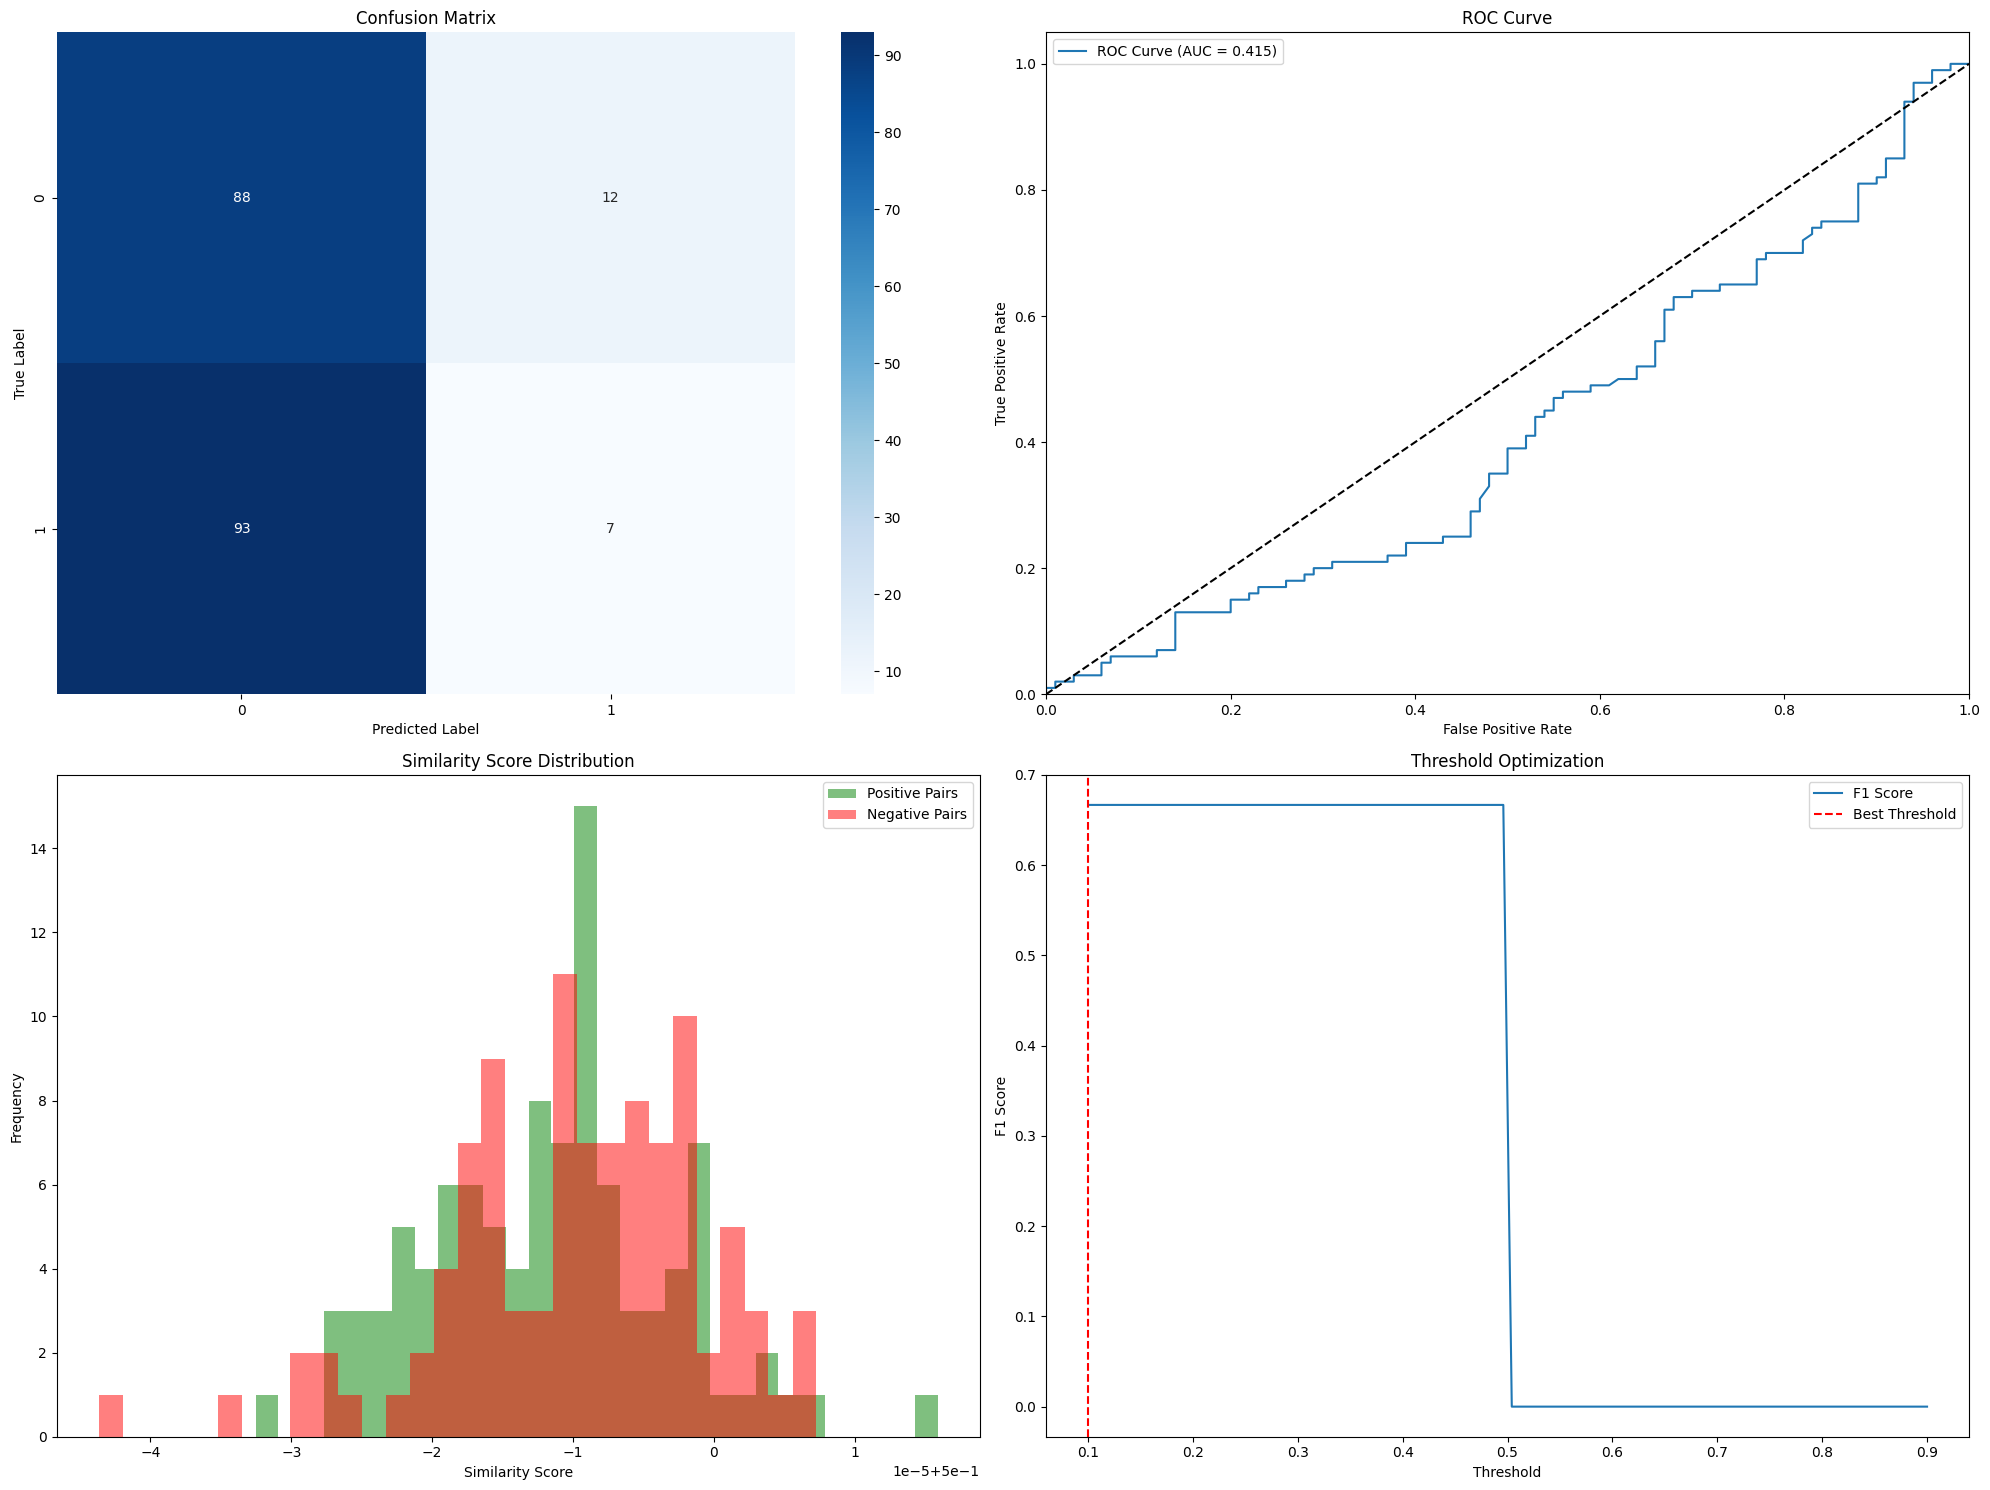

In [3]:
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers, Model
import numpy as np
import cv2
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import random
import os
import pandas as pd

class SiameseNetwork:
    """Siamese Network implementation for face verification."""

    def __init__(self, input_shape=(224, 224, 3)):
        self.input_shape = input_shape
        self.base_network = None
        self.siamese_model = None

    def create_base_network(self):
        """Create the base CNN network that will be shared between twins."""
        input_layer = layers.Input(shape=self.input_shape)

        x = layers.Conv2D(64, (10, 10), activation='relu')(input_layer)
        x = layers.MaxPooling2D(2, 2)(x)
        x = layers.Conv2D(128, (7, 7), activation='relu')(x)
        x = layers.MaxPooling2D(2, 2)(x)
        x = layers.Conv2D(128, (4, 4), activation='relu')(x)
        x = layers.MaxPooling2D(2, 2)(x)
        x = layers.Conv2D(256, (4, 4), activation='relu')(x)
        x = layers.MaxPooling2D(2, 2)(x)
        x = layers.Flatten()(x)
        x = layers.Dense(4096, activation='sigmoid')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(512, activation='sigmoid')(x)
        x = layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1))(x)

        self.base_network = Model(input_layer, x, name='base_network')
        return self.base_network

    def create_siamese_model(self):
        """Create the full Siamese network with twin branches."""
        if self.base_network is None:
            self.create_base_network()

        input_a = layers.Input(shape=self.input_shape, name='input_a')
        input_b = layers.Input(shape=self.input_shape, name='input_b')
        encoded_a = self.base_network(input_a)
        encoded_b = self.base_network(input_b)
        l1_distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([encoded_a, encoded_b])
        prediction = layers.Dense(1, activation='sigmoid', name='prediction')(l1_distance)

        self.siamese_model = Model(inputs=[input_a, input_b], outputs=prediction)
        return self.siamese_model

    def compile_model(self, learning_rate=0.0001):
        """Compile the Siamese model."""
        if self.siamese_model is None:
            self.create_siamese_model()
        self.siamese_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

    def train(self, train_pairs, train_labels, validation_pairs, validation_labels,
              epochs=50, batch_size=32):
        """Train the Siamese network."""
        history = self.siamese_model.fit(
            [train_pairs[:, 0], train_pairs[:, 1]], train_labels,
            validation_data=([validation_pairs[:, 0], validation_pairs[:, 1]], validation_labels),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )
        return history

    def predict_similarity(self, img1, img2):
        """Predict similarity between two images."""
        img1 = np.expand_dims(img1, axis=0)
        img2 = np.expand_dims(img2, axis=0)
        similarity_score = self.siamese_model.predict([img1, img2], verbose=0)[0][0]
        return similarity_score

    def get_embedding(self, image):
        """Get feature embedding for a single image."""
        image = np.expand_dims(image, axis=0)
        embedding = self.base_network.predict(image, verbose=0)[0]
        return embedding

class FaceNetModel:
    """FaceNet-inspired implementation for face verification."""

    def __init__(self, input_shape=(160, 160, 3), embedding_dim=128):
        self.input_shape = input_shape
        self.embedding_dim = embedding_dim
        self.model = None

    def create_model(self):
        """Create FaceNet-inspired model architecture."""
        input_layer = layers.Input(shape=self.input_shape)
        x = self._inception_block(input_layer, [64, 96, 128, 16, 32, 32])
        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
        x = self._inception_block(x, [128, 128, 192, 32, 96, 64])
        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
        x = self._inception_block(x, [192, 96, 208, 16, 48, 64])
        x = self._inception_block(x, [160, 112, 224, 24, 64, 64])
        x = self._inception_block(x, [128, 128, 256, 24, 64, 64])
        x = self._inception_block(x, [112, 144, 288, 32, 64, 64])
        x = self._inception_block(x, [256, 160, 320, 32, 128, 128])
        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.4)(x)
        x = layers.Dense(self.embedding_dim)(x)
        x = layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1))(x)

        self.model = Model(input_layer, x, name='facenet_model')
        return self.model

    def _inception_block(self, x, filters):
        """Create an inception-like block."""
        f1, f2_in, f2_out, f3_in, f3_out, f4_out = filters
        conv1 = layers.Conv2D(f1, (1, 1), padding='same', activation='relu')(x)
        conv3_1 = layers.Conv2D(f2_in, (1, 1), padding='same', activation='relu')(x)
        conv3 = layers.Conv2D(f2_out, (3, 3), padding='same', activation='relu')(conv3_1)
        conv5_1 = layers.Conv2D(f3_in, (1, 1), padding='same', activation='relu')(x)
        conv5 = layers.Conv2D(f3_out, (5, 5), padding='same', activation='relu')(conv5_1)
        maxpool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
        maxpool_conv = layers.Conv2D(f4_out, (1, 1), padding='same', activation='relu')(maxpool)
        return layers.concatenate([conv1, conv3, conv5, maxpool_conv], axis=-1)

    def triplet_loss(self, alpha=0.2):
        """Triplet loss function for training."""
        def loss(y_true, y_pred):
            anchor, positive, negative = tf.split(y_pred, 3, axis=0)
            pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
            neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
            basic_loss = pos_dist - neg_dist + alpha
            loss = tf.maximum(basic_loss, 0.0)
            return tf.reduce_mean(loss)
        return loss

    def compile_model(self, learning_rate=0.001):
        """Compile the FaceNet model."""
        if self.model is None:
            self.create_model()
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=self.triplet_loss()
        )

    def get_embedding(self, image):
        """Get face embedding for an image."""
        image = np.expand_dims(image, axis=0)
        embedding = self.model.predict(image, verbose=0)[0]
        return embedding

    def verify_faces(self, img1, img2, threshold=0.7):
        """Verify if two face images belong to the same person."""
        emb1 = self.get_embedding(img1)
        emb2 = self.get_embedding(img2)
        similarity = cosine_similarity([emb1], [emb2])[0][0]
        return similarity > threshold, similarity

class FaceRecognitionSystem:
    """Complete face recognition system combining preprocessing and model inference."""

    def __init__(self, model_type='siamese', model_path=None):
        self.model_type = model_type
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        if model_type == 'siamese':
            self.model = SiameseNetwork()
        else:
            self.model = FaceNetModel()
        if model_path and Path(model_path).exists():
            self.load_model(model_path)

    def preprocess_image(self, image, target_size=(224, 224)):
        """Preprocess image for model input."""
        if len(image.shape) == 3 and image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, target_size)
        image = image.astype(np.float32) / 255.0
        return image

    def detect_faces(self, image):
        """Detect faces in an image."""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, 1.1, 4)
        face_images = [image[y:y+h, x:x+w] for (x, y, w, h) in faces]
        return face_images, faces

    def verify_faces_from_images(self, img1_path, img2_path):
        """Verify faces from two image files."""
        img1 = cv2.imread(img1_path)
        img2 = cv2.imread(img2_path)
        faces1, _ = self.detect_faces(img1)
        faces2, _ = self.detect_faces(img2)
        if len(faces1) == 0 or len(faces2) == 0:
            return False, 0.0, "No faces detected"
        face1 = self.preprocess_image(faces1[0])
        face2 = self.preprocess_image(faces2[0])
        if self.model_type == 'siamese':
            similarity = self.model.predict_similarity(face1, face2)
            is_same = similarity > 0.5
            return is_same, similarity, "Verification complete"
        else:
            is_same, similarity = self.model.verify_faces(face1, face2)
            return is_same, similarity, "Verification complete"

    def save_model(self, path):
        """Save the trained model."""
        if self.model_type == 'siamese':
            self.model.siamese_model.save(path)
        else:
            self.model.model.save(path)

    def load_model(self, path):
        """Load a pre-trained model."""
        if self.model_type == 'siamese':
            self.model.siamese_model = keras.models.load_model(path)
        else:
            self.model.model = keras.models.load_model(path, custom_objects={'loss': self.model.triplet_loss()})

class TrainingPipeline:
    """Training pipeline for face recognition models."""

    @staticmethod
    def create_pairs_dataset(images, labels, num_pairs_per_class=100):
        """Create pairs dataset for Siamese network training."""
        pairs = []
        pair_labels = []
        unique_labels = np.unique(labels)
        for label in unique_labels:
            label_indices = np.where(labels == label)[0]
            if len(label_indices) < 2:
                continue
            for _ in range(num_pairs_per_class):
                idx1, idx2 = np.random.choice(label_indices, 2, replace=False)
                pairs.append([images[idx1], images[idx2]])
                pair_labels.append(1)
        for _ in range(len(pairs)):
            label1, label2 = np.random.choice(unique_labels, 2, replace=False)
            idx1 = np.random.choice(np.where(labels == label1)[0])
            idx2 = np.random.choice(np.where(labels == label2)[0])
            pairs.append([images[idx1], images[idx2]])
            pair_labels.append(0)
        return np.array(pairs), np.array(pair_labels)

    @staticmethod
    def create_triplets_dataset(images, labels, num_triplets_per_class=50):
        """Create triplets dataset for FaceNet training."""
        triplets = []
        unique_labels = np.unique(labels)
        for label in unique_labels:
            label_indices = np.where(labels == label)[0]
            if len(label_indices) < 2:
                continue
            other_labels = unique_labels[unique_labels != label]
            for _ in range(num_triplets_per_class):
                anchor_idx, positive_idx = np.random.choice(label_indices, 2, replace=False)
                negative_label = np.random.choice(other_labels)
                negative_idx = np.random.choice(np.where(labels == negative_label)[0])
                triplets.append([images[anchor_idx], images[positive_idx], images[negative_idx]])
        return np.array(triplets)

class ModelTester:
    """Comprehensive testing framework for face recognition models."""

    def __init__(self, model_system):
        self.model_system = model_system
        self.test_results = {}

    def generate_synthetic_data(self, num_identities=50, images_per_identity=20,
                             image_size=(224, 224, 3), noise_level=0.1):
        """Generate synthetic face-like data for testing."""
        print(f"Generating synthetic dataset: {num_identities} identities, {images_per_identity} images each")
        images = []
        labels = []
        base_patterns = []
        for i in range(num_identities):
            base = np.random.rand(*image_size) * 0.5 + 0.25
            center_y, center_x = image_size[0]//2, image_size[1]//2
            y, x = np.ogrid[:image_size[0], :image_size[1]]
            mask = (x - center_x)**2 + (y - center_y)**2 < (min(image_size[:2])//3)**2
            base[mask] += 0.2
            base[center_y-20:center_y-10, center_x-40:center_x-20] += 0.3
            base[center_y-20:center_y-10, center_x+20:center_x+40] += 0.3
            base_patterns.append(base)

        for identity_id in range(num_identities):
            base_pattern = base_patterns[identity_id]
            for img_id in range(images_per_identity):
                noise = np.random.normal(0, noise_level, image_size)
                variation = base_pattern + noise
                if random.random() > 0.5:
                    angle = np.random.uniform(-10, 10)
                    center = (image_size[1]//2, image_size[0]//2)
                    M = cv2.getRotationMatrix2D(center, angle, 1.0)
                    variation = cv2.warpAffine(variation, M, (image_size[1], image_size[0]))
                variation = np.clip(variation, 0, 1)
                images.append(variation)
                labels.append(identity_id)
        return np.array(images), np.array(labels)

    def load_real_dataset(self, dataset_path, max_identities=None, max_images_per_identity=None):
        """Load a real face dataset."""
        images = []
        labels = []
        identity_names = []
        dataset_path = Path(dataset_path)
        if not dataset_path.exists():
            raise ValueError(f"Dataset path {dataset_path} does not exist")
        identity_folders = [f for f in dataset_path.iterdir() if f.is_dir()]
        if max_identities:
            identity_folders = identity_folders[:max_identities]
        for identity_id, identity_folder in enumerate(identity_folders):
            identity_name = identity_folder.name
            identity_names.append(identity_name)
            image_files = list(identity_folder.glob("*.jpg")) + list(identity_folder.glob("*.png"))
            if max_images_per_identity:
                image_files = image_files[:max_images_per_identity]
            for image_file in image_files:
                try:
                    image = cv2.imread(str(image_file))
                    if image is not None:
                        faces, _ = self.model_system.detect_faces(image)
                        if len(faces) > 0:
                            face = self.model_system.preprocess_image(faces[0])
                            images.append(face)
                            labels.append(identity_id)
                except Exception as e:
                    print(f"Error loading {image_file}: {e}")
        print(f"Loaded {len(images)} images from {len(identity_names)} identities")
        return np.array(images), np.array(labels), identity_names

    def create_test_pairs(self, images, labels, num_positive_pairs=1000, num_negative_pairs=1000):
        """Create positive and negative pairs for testing."""
        positive_pairs = []
        negative_pairs = []
        unique_labels = np.unique(labels)
        positive_count = 0
        while positive_count < num_positive_pairs:
            identity = np.random.choice(unique_labels)
            identity_indices = np.where(labels == identity)[0]
            if len(identity_indices) >= 2:
                idx1, idx2 = np.random.choice(identity_indices, 2, replace=False)
                positive_pairs.append((images[idx1], images[idx2], 1))
                positive_count += 1
        negative_count = 0
        while negative_count < num_negative_pairs:
            identity1, identity2 = np.random.choice(unique_labels, 2, replace=False)
            idx1 = np.random.choice(np.where(labels == identity1)[0])
            idx2 = np.random.choice(np.where(labels == identity2)[0])
            negative_pairs.append((images[idx1], images[idx2], 0))
            negative_count += 1
        all_pairs = positive_pairs + negative_pairs
        np.random.shuffle(all_pairs)
        pair_images_1 = np.array([pair[0] for pair in all_pairs])
        pair_images_2 = np.array([pair[1] for pair in all_pairs])
        pair_labels = np.array([pair[2] for pair in all_pairs])
        return pair_images_1, pair_images_2, pair_labels

    def test_verification_accuracy(self, test_pairs_1, test_pairs_2, test_labels, threshold=0.5):
        """Test face verification accuracy."""
        print("Testing verification accuracy...")
        predictions = []
        similarities = []
        inference_times = []
        for i in range(len(test_pairs_1)):
            start_time = time.time()
            if self.model_system.model_type == 'siamese':
                similarity = self.model_system.model.predict_similarity(test_pairs_1[i], test_pairs_2[i])
                prediction = 1 if similarity > threshold else 0
            else:
                is_same, similarity = self.model_system.model.verify_faces(test_pairs_1[i], test_pairs_2[i])
                prediction = 1 if is_same else 0
            end_time = time.time()
            inference_times.append(end_time - start_time)
            predictions.append(prediction)
            similarities.append(similarity)
            if (i + 1) % 100 == 0:
                print(f"Processed {i + 1}/{len(test_pairs_1)} pairs")

        accuracy = accuracy_score(test_labels, predictions)
        precision = precision_score(test_labels, predictions)
        recall = recall_score(test_labels, predictions)
        f1 = f1_score(test_labels, predictions)
        fpr, tpr, thresholds = roc_curve(test_labels, similarities)
        roc_auc = auc(fpr, tpr)

        results = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'avg_inference_time': np.mean(inference_times),
            'predictions': predictions,
            'similarities': similarities,
            'true_labels': test_labels,
            'fpr': fpr,
            'tpr': tpr,
            'thresholds': thresholds
        }
        self.test_results['verification'] = results
        return results

    def test_threshold_optimization(self, similarities, true_labels, thresholds=None):
        """Find optimal threshold for best performance."""
        if thresholds is None:
            thresholds = np.linspace(0.1, 0.9, 100)
        best_threshold = 0.5
        best_f1 = 0
        threshold_results = []
        for threshold in thresholds:
            predictions = (np.array(similarities) > threshold).astype(int)
            accuracy = accuracy_score(true_labels, predictions)
            precision = precision_score(true_labels, predictions, zero_division=0)
            recall = recall_score(true_labels, predictions, zero_division=0)
            f1 = f1_score(true_labels, predictions, zero_division=0)
            threshold_results.append({
                'threshold': threshold,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            })
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        self.test_results['threshold_optimization'] = {
            'best_threshold': best_threshold,
            'best_f1': best_f1,
            'all_results': threshold_results
        }
        return best_threshold, threshold_results

    def test_embedding_quality(self, images, labels, sample_size=500):
        """Test quality of embeddings (for FaceNet)."""
        if self.model_system.model_type != 'facenet':
            print("Embedding quality test is only available for FaceNet models")
            return None
        print("Testing embedding quality...")
        if len(images) > sample_size:
            indices = np.random.choice(len(images), sample_size, replace=False)
            sample_images = images[indices]
            sample_labels = labels[indices]
        else:
            sample_images = images
            sample_labels = labels
        embeddings = [self.model_system.model.get_embedding(img) for img in sample_images]
        embeddings = np.array(embeddings)
        intra_class_distances = []
        inter_class_distances = []
        unique_labels = np.unique(sample_labels)
        for label in unique_labels:
            label_indices = np.where(sample_labels == label)[0]
            if len(label_indices) < 2:
                continue
            for i in range(len(label_indices)):
                for j in range(i + 1, len(label_indices)):
                    dist = np.linalg.norm(embeddings[label_indices[i]] - embeddings[label_indices[j]])
                    intra_class_distances.append(dist)
            other_labels = unique_labels[unique_labels != label]
            for other_label in other_labels[:5]:
                other_indices = np.where(sample_labels == other_label)[0][:5]
                for idx1 in label_indices[:5]:
                    for idx2 in other_indices:
                        dist = np.linalg.norm(embeddings[idx1] - embeddings[idx2])
                        inter_class_distances.append(dist)
        embedding_results = {
            'embedding_dim': embeddings.shape[1],
            'intra_class_mean': np.mean(intra_class_distances),
            'intra_class_std': np.std(intra_class_distances),
            'inter_class_mean': np.mean(inter_class_distances),
            'inter_class_std': np.std(inter_class_distances),
            'separation_ratio': np.mean(inter_class_distances) / np.mean(intra_class_distances)
        }
        self.test_results['embedding_quality'] = embedding_results
        return embedding_results

    def plot_results(self, save_path=None):
        """Plot comprehensive test results."""
        if not self.test_results:
            print("No test results to plot. Run tests first.")
            return
        fig = plt.figure(figsize=(20, 15))
        if 'verification' in self.test_results:
            # Confusion Matrix
            plt.subplot(2, 2, 1)
            cm = confusion_matrix(self.test_results['verification']['true_labels'],
                                self.test_results['verification']['predictions'])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')

            # ROC Curve
            plt.subplot(2, 2, 2)
            plt.plot(self.test_results['verification']['fpr'],
                    self.test_results['verification']['tpr'],
                    label=f'ROC Curve (AUC = {self.test_results["verification"]["roc_auc"]:.3f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.legend()

            # Similarity Score Distribution
            plt.subplot(2, 2, 3)
            true_labels = self.test_results['verification']['true_labels']
            similarities = self.test_results['verification']['similarities']
            positive_sims = [s for s, l in zip(similarities, true_labels) if l == 1]
            negative_sims = [s for s, l in zip(similarities, true_labels) if l == 0]
            plt.hist(positive_sims, bins=30, alpha=0.5, label='Positive Pairs', color='green')
            plt.hist(negative_sims, bins=30, alpha=0.5, label='Negative Pairs', color='red')
            plt.xlabel('Similarity Score')
            plt.ylabel('Frequency')
            plt.title('Similarity Score Distribution')
            plt.legend()

            # Threshold Optimization
            if 'threshold_optimization' in self.test_results:
                plt.subplot(2, 2, 4)
                thresholds = [r['threshold'] for r in self.test_results['threshold_optimization']['all_results']]
                f1_scores = [r['f1_score'] for r in self.test_results['threshold_optimization']['all_results']]
                plt.plot(thresholds, f1_scores, label='F1 Score')
                plt.axvline(x=self.test_results['threshold_optimization']['best_threshold'],
                          color='r', linestyle='--', label='Best Threshold')
                plt.xlabel('Threshold')
                plt.ylabel('F1 Score')
                plt.title('Threshold Optimization')
                plt.legend()

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Example Usage
if __name__ == "__main__":
    # Initialize face recognition system
    face_recognition = FaceRecognitionSystem(model_type='siamese')
    face_recognition.model.compile_model()

    # Initialize tester
    tester = ModelTester(face_recognition)

    # Generate synthetic data for testing
    images, labels = tester.generate_synthetic_data(
        num_identities=10,
        images_per_identity=20,
        image_size=(224, 224, 3)
    )

    # Create test pairs
    test_pairs_1, test_pairs_2, test_labels = tester.create_test_pairs(
        images, labels, num_positive_pairs=100, num_negative_pairs=100
    )

    # Test verification accuracy
    results = tester.test_verification_accuracy(test_pairs_1, test_pairs_2, test_labels)
    print(f"Verification Results: Accuracy={results['accuracy']:.3f}, "
          f"Precision={results['precision']:.3f}, Recall={results['recall']:.3f}, "
          f"F1={results['f1_score']:.3f}, ROC AUC={results['roc_auc']:.3f}")

    # Optimize threshold
    best_threshold, threshold_results = tester.test_threshold_optimization(
        results['similarities'], results['true_labels']
    )
    print(f"Best Threshold: {best_threshold:.3f}")

    # Plot results
    tester.plot_results(save_path='test_results.png')

    # Example: Verify two images
    # result, similarity, message = face_recognition.verify_faces_from_images(
    #     'path/to/image1.jpg',
    #     'path/to/image2.jpg'
    # )
    # print(f"Verification: {message}, Same person: {result}, Similarity: {similarity:.3f}")